In [232]:
import pandas as pd
import geopandas
import numpy as np
from math import pi
from matplotlib import pyplot as plt
import seaborn as sns

### Funciones auxiliares

In [233]:
font_size = 18

def crear_radar(categorias, datos_a, datos_b, leyenda_a, leyenda_b, titulo):
    #Basado en https://python-graph-gallery.com/391-radar-chart-with-several-individuals/
    N = len(categorias)
    angulos = [n / float(N) * 2 * pi for n in range(N)]
    angulos += angulos[:1]

    ax = plt.subplot(111, polar=True)
    
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angulos[:-1], categorias)
    
    ax.set_rlabel_position(0)
    plt.yticks([1, 2, 3, 4, 5], ["1", "2", "3", "4", "5"], color="grey", size=8)
    plt.ylim(0,5)
    
    values = list(datos_a)
    values += values[:1]
    ax.plot(angulos, values, linewidth=2, linestyle='solid', markerfacecolor='blue', label=leyenda_a)
    ax.fill(angulos, values, 'b', alpha=0.1)

    values = list(datos_b)
    values += values[:1]
    ax.plot(angulos, values, linewidth=2, linestyle='solid', markerfacecolor='yellow',label=leyenda_b)
    ax.fill(angulos, values, 'y', alpha=0.1)
    
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.title(titulo, size=font_size, y=1.1)

def crear_mapa(series, caracteristica,vmin, vmax, titulo, color):
    #Creo mi mapa de mexico
    mexico = geopandas.read_file('Data/mexstates.shp') #Los estados pueden ser vistos con mexico.ADMIN_NAME

    #Le pongo los tildes al archivo de estados para que me coincidan con las provincias
    mexico["ADMIN_NAME"].replace({'Nuevo Leon': "Nuevo León",
                               "San Luis Potosi": "San luis Potosí",
                               "Queretaro": "Querétaro",
                               "Yucatan": "Yucatán",
                               "Michoacan": "Michoacán",
                               "Mexico": "Edo. de México",
                               "Baja California": "Baja California Norte"}, inplace=True)

    #Hago un nuevo dataframe con la información del mapa y la antiguedad para cada provincia
    gdf = mexico.set_index("ADMIN_NAME").join(series)
    
    #Grafico el mapa

    #Base donde se va a dibujar
    fig, base = plt.subplots(1, figsize=(10, 6))

    #Saco los ejes de lat y lng ya que no aportan al gráfico
    base.axis("off")

    #Pido que me coloreé en base a la antiguedad
    gdf.plot(column=caracteristica, cmap=color, linewidth=0.8, ax=base, edgecolor="0.8")

    #Setteo el título al gráfico
    base.set_title(titulo, fontsize = font_size)
    
    #Agrego la barra que indica la antiguedad
    sm = plt.cm.ScalarMappable(cmap="cividis_r", norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = fig.colorbar(sm)

### Carga optimizada del set de datos

In [234]:
df = pd.read_csv('train.csv', \
       dtype = { \
                'id' : np.int32, \
                'tipodepropiedad' : 'category', \
                'provincia' : 'category', \
                'ciudad' : 'category', \
                'antiguedad' : np.float16, \
                'habitaciones' : np.float16, \
                'garages' : np.float16, \
                'banos' : np.float16, \
                'metroscubiertos' : np.float16, \
                'metrostotales' : np.float16, \
                'idzona' : np.float32, \
                'gimnasio' : 'bool', \
                'usosmultiples' : 'bool', \
                'piscina' : 'bool', \
                'escuelascercanas' : 'bool', \
                'centroscomercialescercanos' : 'bool', \
                'precio' : np.float32 \
               },
        parse_dates = ['fecha'],
        date_parser = pd.to_datetime                                
    )

df = df.dropna(subset=['provincia'])
df = df.dropna(subset=['antiguedad'])

df.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.0,3.0,2.0,...,24514.0,19.310205,-99.227655,2013-06-28,False,False,False,True,True,3600000.0
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.0,3.0,2.0,...,48551.0,NaN,NaN,2015-10-17,False,False,False,False,False,1200000.0
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.0,2.0,1.0,...,53666.0,19.301890,-99.688015,2012-03-09,False,False,False,True,True,650000.0
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.0,2.0,1.0,...,47835.0,NaN,NaN,2016-06-07,False,False,False,False,False,1150000.0
5,126147,departamento en venta taxqueña,"amplio departamento, estancia de sala y comedo...",Apartamento,Condominio Tlalpan 2B,Coyoacán,Distrito Federal,5.0,2.0,1.0,...,23650.0,19.300612,-99.148475,2014-03-18,False,False,False,False,True,1100000.0


## Ubicación de las propiedades más antiguas y más nuevas

### Top 50 propiedades más antiguas

In [235]:
propiedades_mas_antiguas_df = df.nlargest(50, ["antiguedad"])
propiedades_mas_antiguas_df[["provincia", "ciudad", "tipodepropiedad", "antiguedad"]]

,provincia,ciudad,tipodepropiedad,antiguedad
17187,Distrito Federal,Alvaro Obregón,Casa,80.0
22382,Distrito Federal,Cuauhtémoc,Casa,80.0
29801,Distrito Federal,Gustavo A. Madero,Apartamento,80.0
49686,Distrito Federal,Miguel Hidalgo,Casa,80.0
57696,Distrito Federal,Cuauhtémoc,Apartamento,80.0
64234,Distrito Federal,Cuauhtémoc,Edificio,80.0
65640,Distrito Federal,Cuauhtémoc,Casa,80.0
69919,Distrito Federal,Cuauhtémoc,Casa,80.0
97548,Distrito Federal,Cuauhtémoc,Casa,80.0
116874,Aguascalientes,Aguascalientes,Casa,80.0


### Top 50 propiedades más nuevas

In [236]:
propiedades_mas_nuevas_df = df.nsmallest(50, ["antiguedad"])
propiedades_mas_nuevas_df[["provincia", "ciudad", "tipodepropiedad", "antiguedad"]]

,provincia,ciudad,tipodepropiedad,antiguedad
10,San luis Potosí,San Luis Potosí,Casa,0.0
12,Querétaro,Querétaro,Casa,0.0
16,Querétaro,Querétaro,Casa,0.0
19,Querétaro,Querétaro,Casa,0.0
20,Nuevo León,Monterrey,Terreno,0.0
22,Tamaulipas,Ciudad Madero,Casa,0.0
30,Tamaulipas,Ciudad Madero,Apartamento,0.0
33,San luis Potosí,San Luis Potosí,Casa,0.0
35,Morelos,Emiliano Zapata,Casa en condominio,0.0
48,Querétaro,Querétaro,Casa,0.0


### Comparación de las características promedios de ambos tops:

In [237]:
categorias = ["habitaciones", "banos", "piscina", "garages", "gimnasio", "usosmultiples"]
caract_propiedades_mas_antiguas = propiedades_mas_antiguas_df[categorias].mean()
caract_propiedades_mas_nuevas = propiedades_mas_nuevas_df[categorias].mean()

In [238]:
caract_propiedades_mas_antiguas_df = caract_propiedades_mas_antiguas.to_frame()
caract_propiedades_mas_antiguas_df.columns = ["promedio"]
caract_propiedades_mas_antiguas_df

,promedio
habitaciones,3.951220
banos,2.097561
piscina,0.020000
garages,1.051282
gimnasio,0.020000
usosmultiples,0.020000


In [239]:
caract_propiedades_mas_nuevas_df = caract_propiedades_mas_nuevas.to_frame()
caract_propiedades_mas_nuevas_df.columns = ["promedio"]
caract_propiedades_mas_nuevas_df

,promedio
habitaciones,2.978261
banos,2.139535
piscina,0.120000
garages,1.723404
gimnasio,0.100000
usosmultiples,0.180000


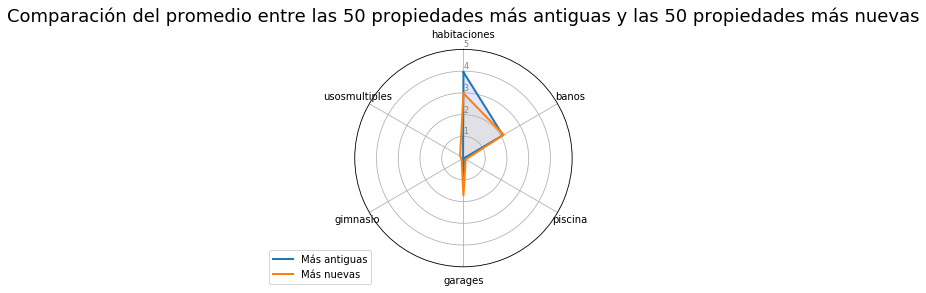

In [240]:
crear_radar(categorias, caract_propiedades_mas_antiguas, caract_propiedades_mas_nuevas,
           "Más antiguas", "Más nuevas", "Comparación del promedio entre las 50 propiedades más antiguas y las 50 propiedades más nuevas")

### Ubicación de las provincias más antiguas y más nuevas

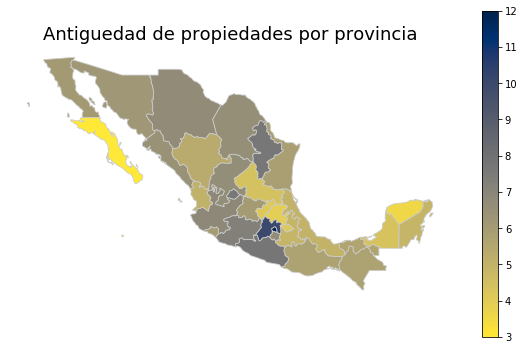

In [241]:
provincia_antiguedad = df.groupby("provincia")["antiguedad"].mean()

crear_mapa(provincia_antiguedad, "antiguedad", 3, 12, "Antiguedad de propiedades por provincia", "cividis_r")